### Testbed for constructing Binance Market Module
1. Create module to ingest data as flat files
2. Allow for pagination to resolve for API rate limit
3. Daily data upload from Binance API
4. Create module to retrieve files

In [423]:
# Binance Market Module Testbed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime as dt
from dateutil.relativedelta import relativedelta
import math
import os
import requests  # requests module to interact with endpoints

In [666]:
# construct class to store exchange information and ingest data, for Spot
class BinanceMarketModule:
    
    # provide class variables
    spot_base_url = 'https://api3.binance.com'
    lin_futures_base_url = 'https://fapi.binance.com'
    inv_futures_base_url = 'https://dapi.binance.com'
    
    # store symbolmaster paths
    spot_smpath = 'spot_symbolmaster.feather'
    lin_futures_smpath = 'lin_symbolmaster.feather'
    inv_futures_smpath = 'inv_symbolmaster.feather'
    
    # wait time
    wait = 0.1
    
    # intervals: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
    
    # initialise constructor to token_type input
    def __init__(self, token_type: str):
        self.token_type = token_type
        self._assign_api()  # assign the right api
        self.base_url = self._assign_api()
        self.smpath = self._smpath()
        self.symbolmaster = None
        self.tokenlist = None
        self.parent_dir = os.getcwd()
        self.data_dir = os.path.join(self.parent_dir, 'data')
        
        # construct empty data directory if it does not exist
        if not os.path.exists(self.data_dir):
            os.mkdir(self.data_dir)
        
    # update symbolmaster
    def pullSymbolMaster(self) -> pd.DataFrame:
        # check if symbolmaster already exists in local directory
        self.smpath= self._smpath()
        if os.path.exists(self.smpath):
            df = pd.read_feather(self.smpath)

        # if symbolmaster does not currently exist, construct new symbolmaster
        else:
            exchange_url = '/api/v3/exchangeInfo'
            endpoint = self.base_url + exchange_url
            response = self._get(endpoint)
            symbolmaster_cols = ['symbol', 'status', 'baseAsset', 'quoteAsset']
            df = pd.DataFrame(response['symbols'])[symbolmaster_cols]
            df['timestamp_utc'] = dt.datetime.now(dt.timezone.utc)
            df['date_utc'] = df['timestamp_utc'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
        
        self.symbolmaster = df
        self.tokenlist = df['symbol'].values
        return self.symbolmaster
    
    # store symbolmaster as feather
    def storeSymbolMaster(self):
        # if it currently does not exist
        if self.symbolmaster is None:
            self.pullSymbolMaster()
        # if symbolmaster exists
        else:
            self.symbolmaster.to_feather(self.smpath)
            print(f'Symbol Master stored as {self.smpath}')
        return self.symbolmaster
    
    # single pull ticker data
    def pullOHLCV(self, symbol: str, interval: str, start: str, end: str)-> pd.DataFrame:
        # manage duration; start and end formatted as string
        unix_start = self.string_to_unixtime(start)
        unix_end = self.string_to_unixtime(end)
        kline_url = '/api/v3/klines'
        full_url = self.base_url + kline_url
        params = {'symbol': symbol,
                  'interval': interval,
                  'limit': 1000,
                  'startTime': unix_start,
                  'endTime': unix_end
                 }
        result = self._get(full_url, params=params)
        cols = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades']
        df = pd.DataFrame(result).iloc[:, :7]
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time']
        df['open_ts'] = df['open_time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000))
        df['close_ts'] = df['close_time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000))
        df['symbol'] = symbol
        df = df[['symbol', 'open_ts', 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 
                'close_ts']]

        # convert prices to float
        df['open'] = df['open'].astype(float)
        df['high'] = df['high'].astype(float)
        df['low'] = df['low'].astype(float)
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        return df
    
    # pull klines by date, with pagination
    def pullBulkOHLCV(self, symbol: str, interval: str, start: str, end: str) -> pd.DataFrame:
        # initiate bulk pull
        bulk_list = []
        new_start = start  # comparison variable
        
        while new_start < end:
            df = self.pullOHLCV(symbol, interval, new_start, end)
            bulk_list.append(df)
            first_close = df['close_ts'].iloc[0].strftime('%Y-%m-%d %H:%M:%S')  # convert to string format
            last_close = df['close_ts'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
            last_open = df['open_ts'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S')
            
            # update new start to last close
            new_start = last_close
            
            # exit loop if exceeded intended last time
            if new_start > end:
                break
                
        # merge dataframes
        agg_df = pd.concat(bulk_list, axis=0) # merge all dataframes together
        agg_df.reset_index(drop=True, inplace=True) # reset index
        agg_df.drop(agg_df.index[-1], inplace=True) # exclude last row
        return agg_df
    
    # store bulk OHLCV into local directory, for any duration
    def storeBulkOHLCV(self, symbol: str, interval: str, start_date: str, end_date: str) -> str:
        # after constructing dataframe with pagination, store into local directory
        start_timestring = self.datestring_to_timestring(start_date)
        end_timestring = self.datestring_to_timestring(end_date)
        df = self.pullBulkOHLCV(symbol, interval, start_timestring, end_timestring)
        
        # save in appropriate format
        ohlcv_path = symbol + '_' + interval + '_' + start_date + '_' + end_date
        df.to_feather(os.path.join(self.data_dir, ohlcv_path))
        first_open = df['open_ts'].iloc[0]
        last_close = df['close_ts'].iloc[-1]
        #print(f'{symbol} for {interval} interval stored for duration {first_open} to {last_close}')
        return df
        
    # update data store and arrange files into library
    def singleUpdateDataStore(self, symbol: str, interval: str, start_date: str, end_date: str):
        # construct sequence of all date breaks, correcting start date to be always first day of month
        
        # determine step based on interval
        date_step, step_format = self._manage_library(interval)
        
        # if start date is not first day of month, then change start date
        if int(dt.datetime.strptime(start_date, '%Y-%m-%d').strftime('%d')) != 1:            
            start_date = dt.datetime.strptime(dt.datetime.strptime(start_date, '%Y-%m-%d').strftime(step_format), step_format).strftime('%Y-%m-%d')
        
        # if end date is not first day of month, then change end date
        if int(dt.datetime.strptime(end_date, '%Y-%m-%d').strftime('%d')) != 1:
            end_date = (dt.datetime.strptime(dt.datetime.strptime(end_date, '%Y-%m-%d').strftime(step_format), step_format) + relativedelta(months=date_step)).strftime('%Y-%m-%d')
                
        # start constructing sequence
        date_sequence = []
        while start_date < end_date:
            date_sequence.append(start_date)
            start_date = (dt.datetime.strptime(start_date, '%Y-%m-%d') + relativedelta(months=date_step)).strftime('%Y-%m-%d')

        # use date sequence to store files
        for i in range(len(date_sequence) - 1):
            start = date_sequence[i]
            end = date_sequence[i+1]
            filepath = symbol + '_' + interval + '_' + start + '_' + end
            full_filepath = os.path.join(self.data_dir, filepath)
            
            # check if file already exists
            if os.path.exists(full_filepath):
                print(f'File {filepath} already exists in DataStore')
                continue
                
            # if file currently does not exist, then construct new file
            else:
                self.storeBulkOHLCV(symbol, interval, start, end)
                print(f'New File {filepath} constructed in DataStore')
                
                # implement wait time to avoid hitting api rate limit
                time.sleep(self.wait)
    
    # retrieve and reconstruct from local directory
    def retrieveOHLCV(self, symbol: str, interval: str, start_date: str, end_date: str):
        # determine step based on interval
        date_step, step_format = self._manage_library(interval)
        
        # construct file paths for retrieval, with addition of latest
        filepaths = self._get_filepaths_retrieval(symbol, interval, start_date, end_date)
        
        # loop through and construct aggregated dataframe
        df_list = []
        for fp in filepaths:
            df = pd.read_feather(os.path.join(self.data_dir, fp))
            df_list.append(df)
        
        # merge all dataframes and reset index
        overall_df = pd.concat(df_list, axis=0)
        overall_df.reset_index(drop=True, inplace=True)
        
        # drop excess data outside of selected range
        output = overall_df[(overall_df['open_ts'] < end_date) & (overall_df['open_ts'] >= start_date)]
        return output
    
    # assign appropriate api_urls
    def _assign_api(self) -> str:
        if self.token_type == 'spot':
            self.base_url = self.spot_base_url
        elif self.token_type == 'lin_future':
            self.base_url = self.lin_futures_base_url
        elif self.token_type == 'inv_future':
            self.base_url = self.inv_futures_base_url
        else:
            self.base_url = None
            print('Unknown Token Type')
        return self.base_url
            
    # get request for usage within the class
    def _get(self, full_endpoint: str, params: dict = None):
        r = requests.get(full_endpoint, params=params)
        results = r.json()
        return results
    
    def _smpath(self) -> str:
        if self.token_type == 'spot':
            self.smpath = self.spot_smpath
        elif self.token_type == 'lin_future':
            self.smpath = self.lin_futures_smpath
        elif self.token_type == 'inv_future':
            self.smpath = self.inv_futures_smpath
        else:
            self.smpath = None
            print('Unknown Token Type')
        return self.smpath
    
    # library management heuristics
    def _manage_library(self, interval: str):
        # implement simple library management heuristics, to return package size
        if interval == '1m':
            package_size = 1  # months
            step_format = '%Y-%m'
        elif interval == '1h':
            package_size = 1 # months
            step_format = '%Y-%m'
        elif interval == '1d':
            package_size = 12 # months
            step_format = '%Y'
        else:
            print('Choose appropriate interval - 1m, 1h or 1d')
            package_size = None
        return package_size, step_format
    
    # construct file date sequence list, ensure files collected inclusive of all in selected date range
    def _get_filepaths_retrieval(self, symbol: str, interval:str, start_date: str, end_date: str) -> list:
        files = []
        
        # determine step based on interval
        date_step, step_format = self._manage_library(interval)
        
        # start constructing date sequence
        date_sequence = []
        
        # select one date step beyond range, normalise file start to start of month
        file_start = dt.datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y-%m-01')
        
        # while start_date < end_date:
        while dt.datetime.strptime(file_start, '%Y-%m-%d') < dt.datetime.strptime(end_date, '%Y-%m-%d') + relativedelta(months=date_step):
            date_sequence.append(file_start)
            file_start = (dt.datetime.strptime(file_start, '%Y-%m-%d') + relativedelta(months=date_step)).strftime('%Y-%m-%d')

        # construct filepaths
        for i in range(len(date_sequence) - 1):
            start = date_sequence[i]
            end = date_sequence[i+1]
            filepath = symbol + '_' + interval + '_' + start + '_' + end
            files.append(filepath)
                        
        return files
    
    # create methods for handling time conversions
    @staticmethod
    def string_to_unixtime(timestring: str):  # convert this into UTC unixtime
        unixtime = time.mktime(dt.datetime.strptime(timestring, '%Y-%m-%d %H:%M:%S').timetuple()) * 1000
        return int(unixtime)
    
    @staticmethod
    def datestring_to_timestring(datestring: str):  # convert this into UTC unixtime
        ts = dt.datetime.strptime(datestring, '%Y-%m-%d')
        timestring = ts.strftime('%Y-%m-%d %H:%M:%S')
        return timestring

In [667]:
bmod = BinanceMarketModule('spot')
sym = bmod.storeSymbolMaster()
usdt_sym = sym[sym['quoteAsset'] == 'USDT']

In [ ]:
unix_start = self.string_to_unixtime(start)
unix_end = self.string_to_unixtime(end)
kline_url = '/api/v3/klines'
full_url = self.base_url + kline_url
params = {'symbol': symbol,
          'interval': interval,
          'limit': 1000,
          'startTime': unix_start,
          'endTime': unix_end
         }
result = self._get(full_url, params=params)

In [683]:
symbol = 'LTCUSDT'
interval = '1h'
start = '2017-01-10 00:00:00'
end = '2017-02-10 00:00:00'
unix_start = bmod.string_to_unixtime(start)
unix_end = bmod.string_to_unixtime(end)
kline_url = '/api/v3/klines'
full_url = bmod.base_url + kline_url
params = {'symbol': symbol,
          'interval': interval,
          'limit': 1000,
          'startTime': unix_start,
          'endTime': unix_end
         }
result = bmod._get(full_url, params=params)
# df = bmod.pullOHLCV(symbol, interval, start, end)

In [684]:
result

[]

In [681]:
df

,symbol,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
0,LTCUSDT,2017-12-13 11:00:00,1513134000000,272.00,288.00,272.00,276.00,130.86075,1513137599999,2017-12-13 11:59:59.999
1,LTCUSDT,2017-12-13 12:00:00,1513137600000,276.00,288.00,269.99,279.00,606.48130,1513141199999,2017-12-13 12:59:59.999
2,LTCUSDT,2017-12-13 13:00:00,1513141200000,279.00,330.00,279.00,302.00,383.76674,1513144799999,2017-12-13 13:59:59.999
3,LTCUSDT,2017-12-13 14:00:00,1513144800000,302.00,304.11,286.00,291.13,351.59475,1513148399999,2017-12-13 14:59:59.999
4,LTCUSDT,2017-12-13 15:00:00,1513148400000,291.13,296.00,285.00,287.00,165.12420,1513151999999,2017-12-13 15:59:59.999
...,...,...,...,...,...,...,...,...,...,...
995,LTCUSDT,2018-01-23 23:00:00,1516719600000,171.78,177.60,171.78,177.01,2684.46386,1516723199999,2018-01-23 23:59:59.999
996,LTCUSDT,2018-01-24 00:00:00,1516723200000,177.01,186.42,176.41,185.00,4684.79104,1516726799999,2018-01-24 00:59:59.999
997,LTCUSDT,2018-01-24 01:00:00,1516726800000,185.00,186.26,179.21,182.09,3849.51440,1516730399999,2018-01-24 01:59:59.999
998,LTCUSDT,2018-01-24 02:00:00,1516730400000,181.37,185.00,181.37,182.31,2036.10603,1516733999999,2018-01-24 02:59:59.999


In [676]:
# update data store
symbol = 'LTCUSDT'
interval = '1h'
start = '2017-01-10'
end = '2018-01-10'
bmod.singleUpdateDataStore(symbol, interval, start, end)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [673]:
start = '2018-02-17'
end = '2022-11-07'
df = bmod.retrieveOHLCV(symbol, interval, start, end)

In [674]:
df

,symbol,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
351,LTCUSDT,2018-02-17 00:00:00,1518796800000,229.43,233.69,228.34,231.21,21492.49997,1518800399999,2018-02-17 00:59:59.999
352,LTCUSDT,2018-02-17 01:00:00,1518800400000,231.27,235.58,230.11,232.34,18729.76101,1518803999999,2018-02-17 01:59:59.999
353,LTCUSDT,2018-02-17 02:00:00,1518804000000,232.34,232.39,222.00,226.67,29712.17131,1518807599999,2018-02-17 02:59:59.999
354,LTCUSDT,2018-02-17 03:00:00,1518807600000,226.67,229.44,224.46,228.17,15808.96372,1518811199999,2018-02-17 03:59:59.999
355,LTCUSDT,2018-02-17 04:00:00,1518811200000,228.21,228.42,224.80,226.30,8241.66326,1518814799999,2018-02-17 04:59:59.999
...,...,...,...,...,...,...,...,...,...,...
41635,LTCUSDT,2022-11-06 19:00:00,1667732400000,69.35,69.36,68.75,69.22,27191.44600,1667735999999,2022-11-06 19:59:59.999
41636,LTCUSDT,2022-11-06 20:00:00,1667736000000,69.22,69.54,69.04,69.21,13177.38800,1667739599999,2022-11-06 20:59:59.999
41637,LTCUSDT,2022-11-06 21:00:00,1667739600000,69.20,69.50,68.87,68.97,16415.62900,1667743199999,2022-11-06 21:59:59.999
41638,LTCUSDT,2022-11-06 22:00:00,1667743200000,68.98,69.40,68.74,69.29,15796.22700,1667746799999,2022-11-06 22:59:59.999


In [644]:
df[(df['open_ts'] < '2022-11-07') & (df['open_ts'] >= '2022-11-01')]

,symbol,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
42239,BTCUSDT,2022-11-01 00:00:00,1667232000000,20402.60,20533.00,20328.68,20371.87,20988.91618,1667235599999,2022-11-01 00:59:59.999
42240,BTCUSDT,2022-11-01 01:00:00,1667235600000,20370.92,20425.28,20345.06,20373.64,11827.33569,1667239199999,2022-11-01 01:59:59.999
42241,BTCUSDT,2022-11-01 02:00:00,1667239200000,20373.64,20468.89,20356.00,20433.90,11550.60960,1667242799999,2022-11-01 02:59:59.999
42242,BTCUSDT,2022-11-01 03:00:00,1667242800000,20433.90,20438.01,20360.37,20371.72,12193.69642,1667246399999,2022-11-01 03:59:59.999
42243,BTCUSDT,2022-11-01 04:00:00,1667246400000,20371.40,20441.99,20353.77,20401.49,7588.08696,1667249999999,2022-11-01 04:59:59.999
...,...,...,...,...,...,...,...,...,...,...
42378,BTCUSDT,2022-11-06 19:00:00,1667732400000,21263.67,21274.90,21178.01,21255.08,11416.97186,1667735999999,2022-11-06 19:59:59.999
42379,BTCUSDT,2022-11-06 20:00:00,1667736000000,21254.80,21269.99,21218.40,21227.01,8315.31939,1667739599999,2022-11-06 20:59:59.999
42380,BTCUSDT,2022-11-06 21:00:00,1667739600000,21227.82,21249.48,21206.62,21220.48,7613.24964,1667743199999,2022-11-06 21:59:59.999
42381,BTCUSDT,2022-11-06 22:00:00,1667743200000,21219.92,21258.65,21190.81,21225.84,10037.50833,1667746799999,2022-11-06 22:59:59.999


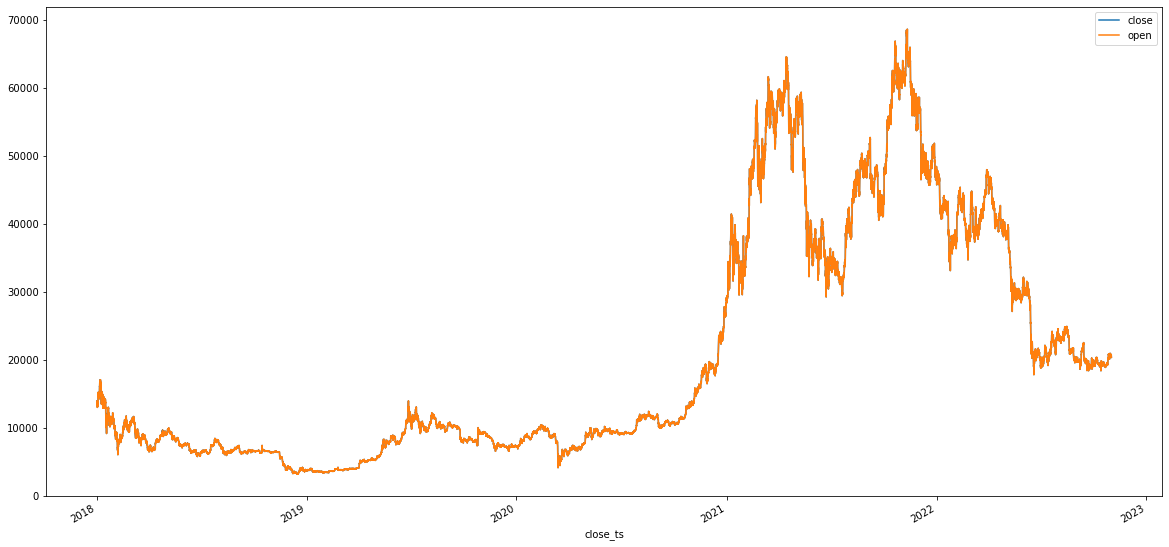

In [619]:
df.set_index('close_ts')[['close', 'open']].plot(figsize=(20, 10))
plt.show()

In [552]:
df = pd.read_feather(os.path.join(bmod.data_dir, 'ETHUSDT_1m_2019-03-01_2019-04-01'))

In [553]:
df

,symbol,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
0,ETHUSDT,2019-03-01 00:00:00,1551369600000,136.75,137.30,136.75,136.92,1694.58470,1551369659999,2019-03-01 00:00:59.999
1,ETHUSDT,2019-03-01 00:01:00,1551369660000,136.97,137.32,136.97,137.09,697.17705,1551369719999,2019-03-01 00:01:59.999
2,ETHUSDT,2019-03-01 00:02:00,1551369720000,137.20,137.90,137.19,137.77,1241.17863,1551369779999,2019-03-01 00:02:59.999
3,ETHUSDT,2019-03-01 00:03:00,1551369780000,137.83,137.98,137.44,137.74,1762.42898,1551369839999,2019-03-01 00:03:59.999
4,ETHUSDT,2019-03-01 00:04:00,1551369840000,137.66,137.71,137.18,137.36,821.90221,1551369899999,2019-03-01 00:04:59.999
...,...,...,...,...,...,...,...,...,...,...
44275,ETHUSDT,2019-03-31 23:55:00,1554047700000,141.16,141.21,141.11,141.15,133.73835,1554047759999,2019-03-31 23:55:59.999
44276,ETHUSDT,2019-03-31 23:56:00,1554047760000,141.13,141.21,141.02,141.02,571.68415,1554047819999,2019-03-31 23:56:59.999
44277,ETHUSDT,2019-03-31 23:57:00,1554047820000,141.04,141.12,141.00,141.05,549.83746,1554047879999,2019-03-31 23:57:59.999
44278,ETHUSDT,2019-03-31 23:58:00,1554047880000,141.05,141.12,141.00,141.03,192.05387,1554047939999,2019-03-31 23:58:59.999


In [525]:
df.to_feather(os.path.join('/data/', 'symbolmaster'))

OSError: Cannot save file into a non-existent directory: '/data'

In [470]:
start = '2021-01-01'
end = '2022-12-05'
df = b.storeBulkOHLCV('ETHUSDT', '1h', start, end)

ETHUSDT for 1h interval stored for duration 2021-01-01 00:00:00 to 2022-12-04 23:59:59.999000


In [464]:
b.singleUpdateDataStore('ETHUSDT', '1h', start, end)

['2021-01-01',
 '2021-02-01',
 '2021-03-01',
 '2021-04-01',
 '2021-05-01',
 '2021-06-01',
 '2021-07-01',
 '2021-08-01',
 '2021-09-01',
 '2021-10-01',
 '2021-11-01',
 '2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2022-12-01']

In [395]:
pd.read_feather('ETHUSDT_1h_2021-01-01_2022-12-01')

,open_ts,open_time,open,high,low,close,volume,close_time,close_ts
0,2021-01-01 00:00:00,1609430400000,736.00,736.97,724.48,727.30,45192.35523,1609433999999,2021-01-01 00:59:59.999
1,2021-01-01 01:00:00,1609434000000,727.26,743.00,726.59,737.20,41547.83481,1609437599999,2021-01-01 01:59:59.999
2,2021-01-01 02:00:00,1609437600000,737.20,740.96,735.28,739.87,18794.08202,1609441199999,2021-01-01 02:59:59.999
3,2021-01-01 03:00:00,1609441200000,739.88,742.00,737.36,738.83,14810.28022,1609444799999,2021-01-01 03:59:59.999
4,2021-01-01 04:00:00,1609444800000,738.76,744.50,737.61,743.96,14700.26345,1609448399999,2021-01-01 04:59:59.999
...,...,...,...,...,...,...,...,...,...
16758,2022-11-30 19:00:00,1669806000000,1264.69,1268.14,1264.46,1266.72,8852.24420,1669809599999,2022-11-30 19:59:59.999
16759,2022-11-30 20:00:00,1669809600000,1266.73,1268.85,1255.10,1258.80,21709.27630,1669813199999,2022-11-30 20:59:59.999
16760,2022-11-30 21:00:00,1669813200000,1258.81,1272.50,1257.70,1262.53,42976.26570,1669816799999,2022-11-30 21:59:59.999
16761,2022-11-30 22:00:00,1669816800000,1262.54,1268.14,1261.76,1266.83,22970.04800,1669820399999,2022-11-30 22:59:59.999


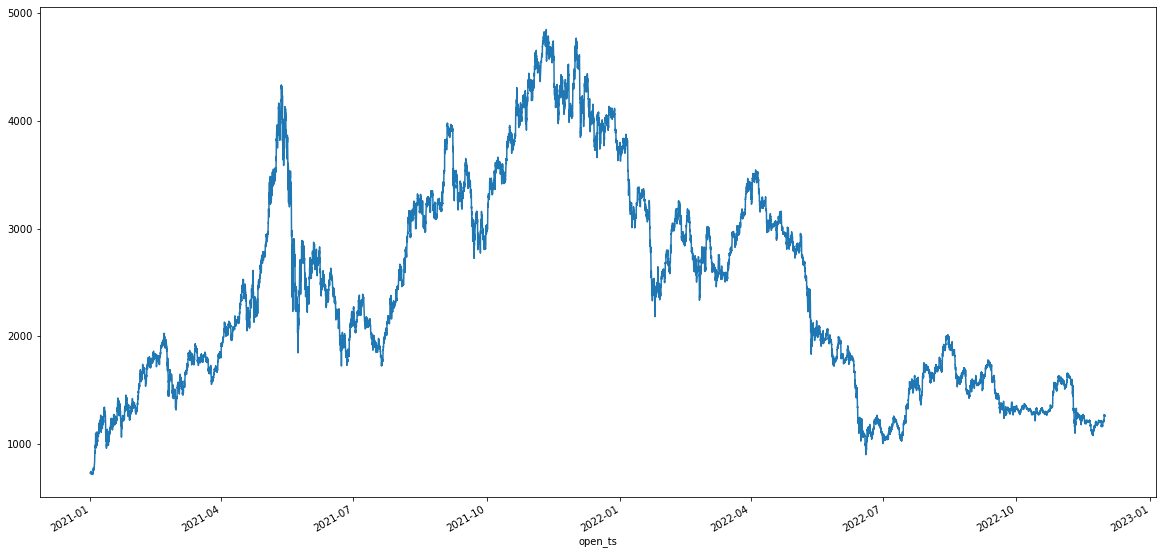

In [399]:
df.set_index('open_ts')['open'].plot(figsize=(20, 10))
plt.show()

In [ ]:
b.storeBulkOHLCV('BTCUSDT', '1m', start, end))

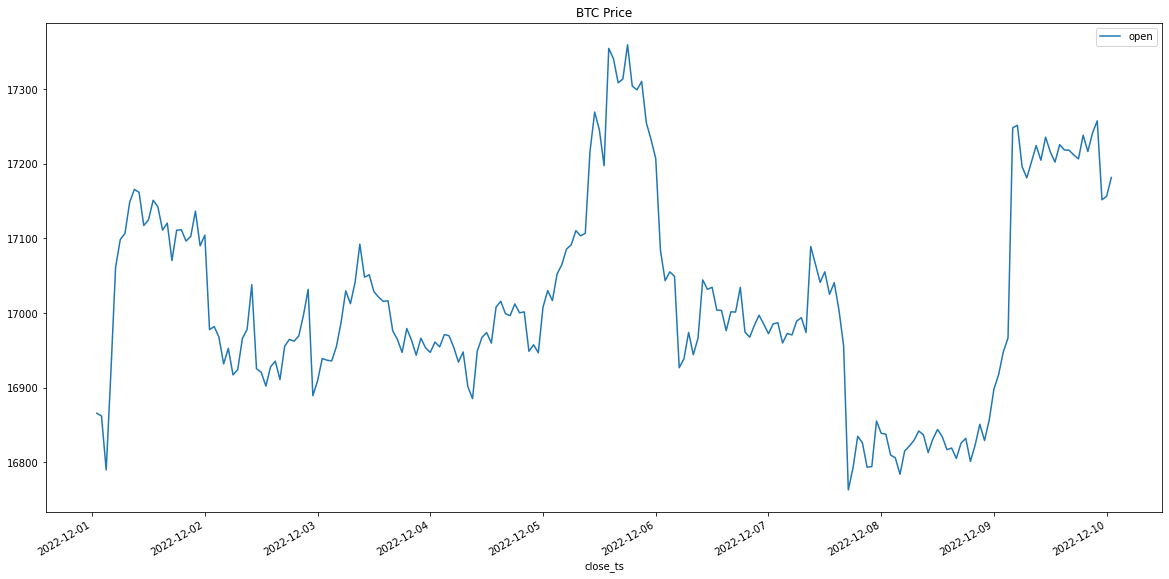

In [273]:
df.set_index('close_ts', inplace=True)
df[['open']].plot(figsize=(20,10), title='BTC Price')
plt.show()

In [436]:
start_date = '2020-01-01'
end_date = '2020-12-31'
# start_date = (dt.datetime.strptime(start_date, '%Y-%m-%d') + relativedelta(months=1))

In [449]:
a = int(dt.datetime.strptime(start_date, '%Y-%m-%d').strftime('%d'))

In [457]:
dt.datetime.strptime(dt.datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y-%m'), '%Y-%m').strftime('%Y-%m-%d')

'2020-01-01'

In [435]:
start_date = '2020-01-01'
end_date = '2020-12-31'

date_sequence = [start_date]
while start_date < end_date:
    start_date = (dt.datetime.strptime(start_date, '%Y-%m-%d') + relativedelta(months=1)).strftime('%Y-%m-%d')
    date_sequence.append(start_date)

In [433]:
date_sequence

['2020-01-01',
 '2020-02-01',
 '2020-03-01',
 '2020-04-01',
 '2020-05-01',
 '2020-06-01',
 '2020-07-01',
 '2020-08-01',
 '2020-09-01',
 '2020-10-01',
 '2020-11-01',
 '2020-12-01',
 '2021-01-01']